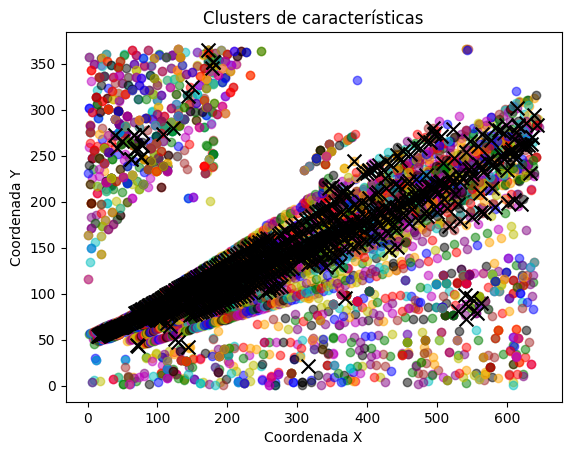

In [2]:
import cv2
import numpy as np
import tkinter as tk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def initialize_tracking(cap, feature_params):
    ret, frame = cap.read()
    if not ret:
        return None, None, None
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(gray_frame, mask=None, **feature_params)
    return gray_frame, p0, None

def draw_clusters(frame, good_new, centroids, labels, cluster_colors):
    if centroids is None or labels is None:
        return frame
    for i, point in enumerate(good_new):
        x, y = point.ravel()
        color = cluster_colors[labels[i]]
        frame = cv2.circle(frame, (int(x), int(y)), 5, color, -1)
    for i, center in enumerate(centroids):
        x, y = center.ravel()
        frame = cv2.circle(frame, (int(x), int(y)), 10, (0, 255, 0), -1)
    return frame

def update_tracking(frame, old_gray, p0, lk_params, color, min_movement=0.03, n_clusters=5):
    if p0 is None or len(p0) == 0:
        return None, None, None
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, p0, None, **lk_params)
    if p1 is None or len(p1) < 10:
        return None, None, None
    good_new = []
    for i, (new, old) in enumerate(zip(p1, p0)):
        if st[i] == 1:
            movement = np.linalg.norm(new.ravel() - old.ravel())
            if movement > min_movement:
                good_new.append(new)
                a, b = new.ravel()
                frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    if len(good_new) > 0:
        centroids, labels = cluster_features(np.array(good_new), n_clusters)
        cluster_colors = [color[i % len(color)].tolist() for i in range(n_clusters)]
        frame = draw_clusters(frame, good_new, centroids, labels, cluster_colors)
    return gray_frame, np.array(good_new).reshape(-1, 1, 2), frame

def cluster_features(good_new, n_clusters=5):
    good_new_array = np.array([point.ravel() for point in good_new])
    if len(good_new_array) < n_clusters:
        return None, None
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(good_new_array)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return centroids, labels

def plot_clusters(good_new, centroids, n_clusters):
    plt.figure()
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    if good_new.size > 0:
        for point in good_new:
            color = colors[np.random.randint(0, len(colors))]
            plt.scatter(point[0], point[1], c=color, alpha=0.5)
    if centroids.size > 0:
        for centroid in centroids:
            plt.scatter(centroid[0], centroid[1], c='black', marker='x', s=100)
    plt.title('Clusters de características')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.show()

def main():
    n_clusters = 5
    all_good_new = []
    all_centroids = []
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana de Tkinter
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    window_width = screen_width // 3
    window_height = screen_height // 3

    cap = cv2.VideoCapture('prvd.mp4')

    feature_params = dict(maxCorners=1000, qualityLevel=0.03, minDistance=7, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=5, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    color = np.random.randint(0, 255, (1000, 3))
    old_gray, p0, _ = initialize_tracking(cap, feature_params)

    ret, first_frame = cap.read()
    if not ret:
        print("Error: Unable to read video frame.")
        return
    resized_first_frame = cv2.resize(first_frame, (window_width, window_height))
    prev_gray = cv2.cvtColor(resized_first_frame, cv2.COLOR_BGR2GRAY)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, (window_width, window_height))
    
        old_gray, p0, feature_tracking_frame = update_tracking(frame, old_gray, p0, lk_params, color)
        if old_gray is None:
            old_gray, p0, _ = initialize_tracking(cap, feature_params)
            if old_gray is None:
                break

        # Acumular datos para los clusters
        if p0 is not None and len(p0) > 0:
            centroids, labels = cluster_features(p0, n_clusters)
            if centroids is not None:
                all_good_new.extend(p0)
                all_centroids.extend(centroids)

        # Procesamiento para el flujo óptico denso
        gray = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.1, flags=0)
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mask = np.zeros_like(resized_frame)
        mask[..., 0] = angle * 180 / np.pi / 2
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        # Mostrar los resultados
        if feature_tracking_frame is not None and feature_tracking_frame.size != 0:
            cv2.imshow('Feature Tracking', feature_tracking_frame)
        if rgb.size != 0:
            cv2.imshow('Dense Optical Flow', rgb)

        if cv2.waitKey(25) & 0xFF == 27:
            break

        prev_gray = gray

    cap.release()
    cv2.destroyAllWindows()
    root.destroy()

    if all_centroids:
        all_good_new_array = np.array(all_good_new).reshape(-1, 2)
        all_centroids_array = np.array(all_centroids).reshape(-1, 2)
        plot_clusters(all_good_new_array, all_centroids_array, n_clusters)

if __name__ == "__main__":
    main()